# Recommenders 1 -- (1h) 

## Goals of this practical:

1. Have a quick statistical tour of a recommendation dataset (~10min)
2. Understand the classical task of rating prediction (~10min)
3. Know and implement really simple but tough baselines (~20min)
4. Use a scikit like library to build explicit recommender sysems (~20min)


## What is collaborative filtering ?

On the internet, people rate items (or simply click on them, showing preference). All these ratings can be seen as a matrix coding for all ratings of size (n_user,n_item). It's worth noting that this matrix is highly sparse: No one rates everything, people only rate a subset of items. **Collaborative filtering** is done by leveraging the similarity in people's rating pattern. It enables to find 


Recommendation (more specifically **collaborative filtering**) goal can be seen as predicting how someone will rate one item. This is akin to filling this matrix, by predicting all missing ratings. The most used algorithms for this task are matrix factorization ones: they take advantage from the fact that a matrix can be decomposed into two sub-matrices: one coding for the users and one coding for the items.

## Why predicting ratings and not directly items:

Theoritically, the goal of a recommender system is to cherry pick interesting items for one user within a huge collection. Rating prediction is a surrogate problem of item prediction. To get what item to recommend you can, for exemple, simply sort best rated items. It has been shown that improving rating prediction actually improve item prediction.


## Data used : [smallest movie-lens dataset](https://grouplens.org/datasets/movielens/)

In this practical we use a small dataset of user ratings on movies. Specifically, we treat the dataset as list of $(user,item,rating)$ triplets.



## Notes: 

We'll be using pandas for data manipulation but it's not needed to know any special tricks. If you have any pandas related questions, just ask !

### Prerequisites:

First, we install and load some packages

In [7]:
## Uncomment this to install required packages if needed (and restart kernel !)
#! pip install --upgrade pandas
#! pip install --upgrade seaborn
#! pip install --upgrade scikit-surprise

In [8]:
import pandas as pd # we'll use pandas for data analysis
import seaborn as sns # we'll use seaborn for nice plots
import numpy as np # we'll use numpy for data also
%matplotlib inline

In [9]:
#Should be 0.25.3
print(pd.__version__)

#Should be 0.9.0
print(sns.__version__)

## These are the version the notebook has been built on. It could work on old ones, or it could not :)

2.2.3
0.13.2


# 1. Let's have a quick statistical tour of the ml-small dataset

This is the [smallest movie-lens dataset](https://grouplens.org/datasets/movielens/) it is a subset of a bigger data set of movie ratings.

> This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

> Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

## First, let's load the data with pandas and see how it looks

In [10]:
ratings = pd.read_csv("dataset/ratings.csv")
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## (WARMUP) Some simple questions we'll try to answer:
- How many users are there ?
- How many items are there ?
- How are ratings distributed ? Per users ? Per items ?
- What is the mean rating ?
...


## TODO: Find how many user and item there are.

In [11]:
ratings["userId"].values #numpy array
ratings["movieId"] #pandas serie
#there are 610 users and 9724 items

num_users  = ratings['userId'].nunique() # To complete
num_items  = ratings['movieId'].nunique() # To complete

print(f"there are {num_users} users and {num_items} items")

there are 610 users and 9724 items


## TODO: Find how sparse the rating matrix is.

Rating data is often though of a user/item matrix. Since each user haven't rated every items this matrix is HIGHLY SPARSE (it's mainly filled with zeros). 
- Find the sparsity of the matrix (spoiler: it's ~1.69% full)

In [12]:
#Rating matrix is only 1.6999683055613624% full

sparsity = (ratings.shape[0] / (num_users * num_items)) * 100  # To complete
print(f"Rating matrix is only {sparsity}% full")

Rating matrix is only 1.6999683055613624% full


## TODO: Lets compute some stats:

- Find the count/mean/std/min/max of ratings 

In [13]:
# To Complete
ratings['rating'].describe()


count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

- Find/plot the global rating distribution

<Axes: xlabel='rating', ylabel='Count'>

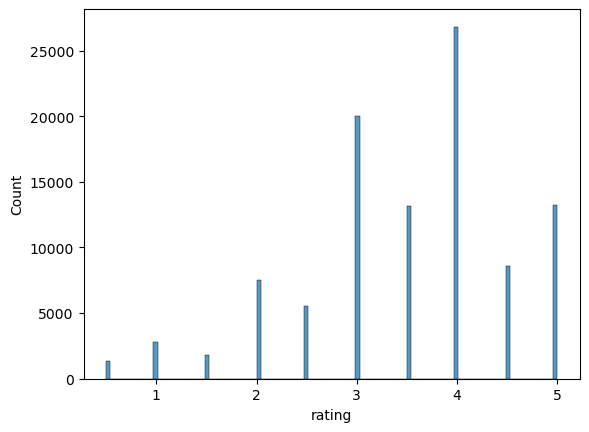

In [14]:
import seaborn as sns
# To Complete
sns.histplot(data=ratings, x='rating')


- Find/plot the user means rating distribution

<Axes: >

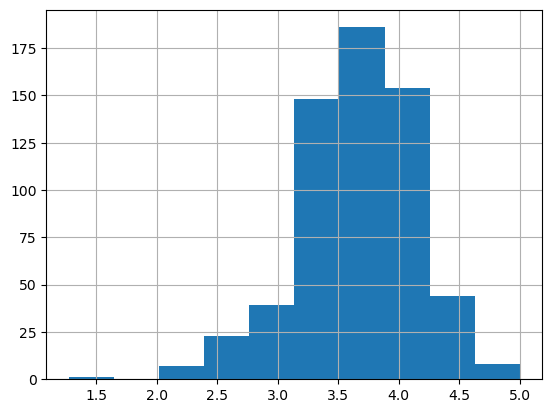

In [15]:
# To Complete
mean_rating_by_user = ratings.groupby('userId')['rating'].mean()
mean_rating_by_user.hist()


- Find/plot the item means rating distribution

<Axes: >

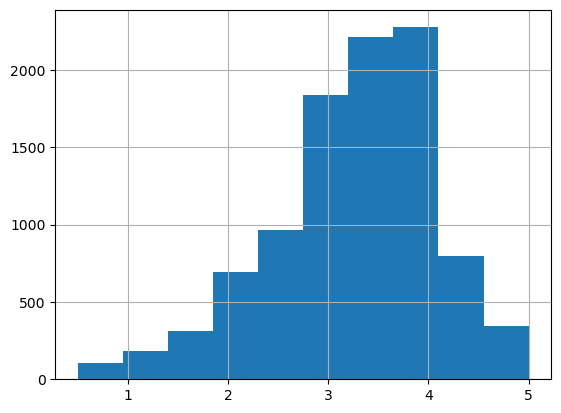

In [16]:
# To Complete
mean_rating_by_movie = ratings.groupby('movieId')['rating'].mean()
mean_rating_by_movie.hist()

In [17]:
type(mean_rating_by_movie)

pandas.core.series.Series

## Stats Takeways:

- as it's often the case on rating data, there is a high biais towards good ratings: people tend to rate things they like more than things they dislike

# (Explicit) Collaborative Filtering  by predicting ratings:

The Netflix competition introduced the following predictive framework: the goal is to predict missing ratings using existing ones.

In short, the goal is to define a model $f$ to predict how a user $u$ would rate an item $i$ : 

### $$ f(u,i) = r_{ui} $$

## First, let's build a train/test set

Here, for simplicity, we take the 1 example out of 5 as a test example.

In [18]:
train_indexes,test_indexes = [],[]

for index in range(len(ratings)):
    if index%5 == 0:
        test_indexes.append(index)
    else:
        train_indexes.append(index)

train_ratings = ratings.iloc[train_indexes].copy()
test_ratings = ratings.iloc[test_indexes].copy()

In [19]:
test_ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
5,1,70,3.0,964982400
10,1,163,5.0,964983650
15,1,260,5.0,964981680
20,1,356,4.0,964980962


In explicit collaborative filtering, the data are triplets of $(user,item,rating)$

Let's see how one item is.

In [20]:
test_ratings[test_ratings["movieId"] == 131724]

,userId,movieId,rating,timestamp
260,2,131724,5.0,1445714851


Given the triplet $(2,131724,5)$, the model goal will be to predict $f(2,131724) = 5$

## Basic Recsys **mean** baselines implementations

First, before digging into more complicated models, we'll implement three really simple baselines:

- The global mean $\mu$
- The user mean $b_u$
- The item mean $b_i$

Indeed, the rating distribution is not uniform at all (it looks more normal). Therefore, the means are good baselines.

## TODO: compute the global training mean, user means and item means

- First, compute basic means to use them as baseline

**NOTE**: User or items can be missing from train-set: be sure to return something in that case

In [21]:
MEAN = train_ratings["rating"].mean()
USER_MEANS = train_ratings.groupby("userId")["rating"].mean()
ITEM_MEANS = train_ratings.groupby("movieId")["rating"].mean()


def mean_rating_pred(user_item):
    user = user_item["userId"]
    item = user_item["movieId"]
    
    return MEAN ## to complete

def user_mean_rating_pred(user_item):
    user = user_item["userId"]
    item = user_item["movieId"]
    
    return USER_MEANS.get(user, MEAN) ## to complete

def item_mean_rating_pred(user_item):
    user = user_item["userId"]
    item = user_item["movieId"]
    
    return ITEM_MEANS.get(item, MEAN) ## to complete


In [22]:
MEAN = train_ratings["rating"].mean()
USER_MEANS = train_ratings.groupby("userId")["rating"].mean()
user = ratings["userId"]

print(type(user))
print(USER_MEANS.get(2, MEAN))
print(USER_MEANS)

<class 'pandas.core.series.Series'>
3.9130434782608696
userId
1      4.345946
2      3.913043
3      2.218750
4      3.581395
5      3.722222
         ...   
606    3.657511
607    3.758389
608    3.132331
609    3.266667
610    3.700768
Name: rating, Length: 610, dtype: float64


These baseline models establish simple benchmarks for recommendation systems.

More advanced models (e.g., collaborative filtering, matrix factorization) can be evaluated against these.

The fallback mechanisms ensure robustness when encountering new users or items.

### You should be able to run the following cell to get mean predictions (instead of None's)

In [23]:
#We create the rating prediction columns
test_ratings["mean_prediction"] = test_ratings[["userId","movieId"]].apply(mean_rating_pred,axis=1)
test_ratings["muser_prediction"] = test_ratings[["userId","movieId"]].apply(user_mean_rating_pred,axis=1) 
test_ratings["mitem_prediction"] = test_ratings[["userId","movieId"]].apply(item_mean_rating_pred,axis=1) 

test_ratings.head(5)

,userId,movieId,rating,timestamp,mean_prediction,muser_prediction,mitem_prediction
0,1,1,4.0,964982703,3.501915,4.345946,3.861446
5,1,70,3.0,964982400,3.501915,4.345946,3.613636
10,1,163,5.0,964983650,3.501915,4.345946,3.584906
15,1,260,5.0,964981680,3.501915,4.345946,4.248691
20,1,356,4.0,964980962,3.501915,4.345946,4.148374


#### Ok, now that we've got some predictions, let's evaluate them:

## Evaluation metrics:

In explicit collaborative filtering there are three common metrics to compare a ground truth $x$ to a predicted $\hat{x}$:

- Mean Average Error (MAE) : $$\frac{1}{n}\sum^n|(x-\hat{x})|$$
- Mean Squared Error (MSE) : $$\frac{1}{n}\sum^n(x-\hat{x})^2$$
- Rooted Mean Squared Error (RMSE) : $$\sqrt{\frac{1}{n}\sum^n(x-\hat{x})^2}$$

## TODO: Implement those metrics

**Note:** The `predictions` and `truth` variables are arrays of predictions/ground_truth

In [31]:
from math import sqrt

def mae(predictions,truth):
    return sum(abs(predictions - truth)) / len(predictions)  ## To complete

def mse(predictions,truth):
    return sum((predictions - truth) ** 2)  ## To complete

def rmse(predictions,truth):
    return sqrt(mse(predictions,truth))  ## To complete


def all_metrics(predictions,truth):
    return [f(predictions,truth) for f in [mae,mse,rmse]]

### You should be able to run the following cell to get the metrics results (Instead of None)

In [32]:
metrics = ["mae","mse","rmse"]
results = pd.DataFrame()

results["metrics"] = metrics
results["mean_prediction"] = all_metrics(test_ratings["mean_prediction"],test_ratings["rating"])
results["muser_prediction"] = all_metrics(test_ratings["muser_prediction"],test_ratings["rating"])
results["mitem_prediction"] = all_metrics(test_ratings["mitem_prediction"],test_ratings["rating"])
results = results.set_index("metrics")

print(results)
print("")
print('---Best Models / Metrics: ---')
results.idxmin(1)

         mean_prediction  muser_prediction  mitem_prediction
metrics                                                     
mae             0.820963          0.729720          0.746088
mse         21714.814404      17734.200261      18897.951431
rmse          147.359473        133.169817        137.469820

---Best Models / Metrics: ---


metrics
mae     muser_prediction
mse     muser_prediction
rmse    muser_prediction
dtype: object

Which Model is Better?

The model with the lowest error is preferred.

The muser_prediction model has the lowest MAE, MSE, and RMSE.

Conclusion:
✅ "muser_prediction" is the best performing model based on all three metrics.

In [34]:
results

,mean_prediction,muser_prediction,mitem_prediction
metrics,,,
mae,0.820963,0.729720,0.746088
mse,21714.814404,17734.200261,18897.951431
rmse,147.359473,133.169817,137.469820


# Basic explicit collaborative filtering models - using surprise library

> Surprise is an easy-to-use Python scikit for recommender systems.

> Surprise has a set of built-in algorithms and datasets for you to play with. In its simplest form, it only takes a few lines of code to run a cross-validation procedure:

[More details on the official documentation](https://surprise.readthedocs.io/en/stable/index.html)

in Surprise, you can perform data splitting and cross-validation in a single line using cross_validate. 

This method will automatically split the data, train the model, and evaluate it.

In [33]:
## Uncomment this to install required packages if needed (and restart kernel !)
! pip install --upgrade scikit-surprise

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-macosx_11_0_arm64.whl size=485174 sha256=e5f1853c541e072ecfaf6d475121e42bcd6ef6123d849857d160171f6b99a512
  Stored in directory: /Users/williamfranz/Library/Caches/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


## Loading custom data

We want to be able to load our custom dataset in the framework data structures.  
To do so, we could either load from a raw file or from a dataframe. We do the latter.

(Here is the [Documentation reference](https://surprise.readthedocs.io/en/stable/getting_started.html#use-a-custom-dataset) for loading custom datasets)

In [35]:
from surprise import NormalPredictor, BaselineOnly, SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(train_ratings[['userId', 'movieId', 'rating']], Reader(rating_scale=(1, 5)))

In [40]:
data.raw_ratings[:5]

[(1, 3, 4.0, None),
 (1, 6, 4.0, None),
 (1, 47, 5.0, None),
 (1, 50, 5.0, None),
 (1, 101, 5.0, None)]

## How do models work in Surprise ?

It's fairly easy, Surprise follows the "scikit" way of doing things:
```python
model = GoodModel(params)
model.fit(train_data)
predictions = model.predict(test_data)
```

Ok, let's dig in:

## The baseline model:

>Typical CF data exhibit large user and item effects—systematic tendencies for
some users to give higher ratings than others—and for some items to receive
higher ratings than others. It is customary to adjust the data by accounting for
these effects, which we encapsulate within the baseline estimates. Denote by
μ the overall average rating. A baseline estimate for an unknown rating r ui is
denoted by b ui and accounts for the user and item effects:

## $$ \hat{r}_{ui} = b_{ui} = \mu + b_u + b_i $$

(If user u is unknown, then the bias bu is assumed to be zero. The same applies for item i with bi.)

> The parameters b u and b i indicate the observed deviations of user u and item i,
respectively, from the average. For example, suppose that we want a baseline
estimate for the rating of the movie Titanic by user Joe. Now, say that the
average rating over all movies, μ, is 3.7 stars. Furthermore, Titanic is better
than an average movie, so it tends to be rated 0.5 stars above the average. On
the other hand, Joe is a critical user, who tends to rate 0.3 stars lower than the
average. Thus, the baseline estimate for Titanic’s rating by Joe would be 3.9
stars by calculating 3.7 − 0.3 + 0.5.

(see [Yehuda Koren. Factor in the neighbors: scalable and accurate collaborative filtering. 2010.](http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf))


在协同过滤（Collaborative Filtering, CF）数据中，存在用户偏差（User Bias）和物品偏差（Item Bias）：

部分用户比其他用户更倾向于给出更高的评分。
部分物品天生比其他物品评分更高。
为了消除这些系统性偏差，我们可以用**基线评分（Baseline Estimates）**进行调整。



## (a) Fit

In [41]:
BaselineModel = BaselineOnly()
BaselineModel.fit(data.build_full_trainset())

Estimating biases using als...


## (b) Predict
If you look at the [Prediction module](https://surprise.readthedocs.io/en/stable/predictions_module.html) documentation,
you'll see that it has a little twist w/ respect to the traditional scikit "predict". It returns a Prediction "[namedTuple](https://docs.python.org/3/library/collections.html#collections.namedtuple)" with the following fields:

- uid – The (raw) user id. (raw means it's the one you supplied, not the one automatically computed by surprise)
- iid – The (raw) item id.
- r_ui (float) – The true rating rui
- est (float) – The estimated rating $r_{ui}$
- details (dict) – Stores additional details about the prediction that might be useful for later analysis.

**=>** if you have a namedTuple `prediction`: `prediction.uid` will contain the user id. 

在 Surprise 库中，predict 方法的返回值是一个包含多个字段的命名元组 (namedTuple)，不同于 scikit-learn 的 predict 方法只返回预测值。在推荐系统中，除了预测评分外，我们可能还需要了解：

用户和物品的 ID（uid, iid）

该用户对该物品的真实评分（如果有）（r_ui）

预测的评分（est）

其他可能的附加信息（details）

这种结构有助于后续的分析，例如评估推荐模型的误差或提取特定用户的推荐结果。🚀









In [42]:
def opt_bl_rating_pred(user_item):
    user = user_item["userId"]
    item = user_item["movieId"]
    
    prediction = BaselineModel.predict(user,item)
    
    return prediction.est

test_ratings["opt_bl_prediction"] = test_ratings[["userId","movieId"]].apply(opt_bl_rating_pred,axis=1) 

test_ratings

,userId,movieId,rating,timestamp,mean_prediction,muser_prediction,mitem_prediction,opt_bl_prediction
0,1,1,4.0,964982703,3.501915,4.345946,3.861446,4.531855
5,1,70,3.0,964982400,3.501915,4.345946,3.613636,4.325943
10,1,163,5.0,964983650,3.501915,4.345946,3.584906,4.268825
15,1,260,5.0,964981680,3.501915,4.345946,4.248691,4.890212
20,1,356,4.0,964980962,3.501915,4.345946,4.148374,4.793284
...,...,...,...,...,...,...,...,...
100815,610,158721,3.5,1479542491,3.501915,3.700768,3.501915,3.638797
100820,610,160341,2.5,1479545749,3.501915,3.700768,3.501915,3.638797
100825,610,161634,4.0,1493848362,3.501915,3.700768,3.166667,3.552825
100830,610,166528,4.0,1493879365,3.501915,3.700768,3.931818,3.935317


In [46]:
metrics = ["mae","mse","rmse"]
results = pd.DataFrame()

results["metrics"] = metrics
results["muser_prediction"] = all_metrics(test_ratings["muser_prediction"],test_ratings["rating"])
results['baseline_prediction'] = all_metrics(test_ratings['opt_bl_prediction'], test_ratings['rating'])
results = results.set_index("metrics")

print(results)
print("")
print('---Best Models / Metrics: ---')
results.idxmin(1)

         muser_prediction  baseline_prediction
metrics                                       
mae              0.729720             0.664942
mse          17734.200261         15096.498685
rmse           133.169817           122.867810

---Best Models / Metrics: ---


metrics
mae     baseline_prediction
mse     baseline_prediction
rmse    baseline_prediction
dtype: object

In [54]:
predictions = []
for _, row in ratings.iterrows():
    pred = BaselineModel.predict(row["userId"], row["movieId"])
    predictions.append(pred)

predictions[:5]


[Prediction(uid=1, iid=1, r_ui=None, est=4.531855314639425, details={'was_impossible': False}),
 Prediction(uid=1, iid=3, r_ui=None, est=4.020270821365498, details={'was_impossible': False}),
 Prediction(uid=1, iid=6, r_ui=None, est=4.605279843448195, details={'was_impossible': False}),
 Prediction(uid=1, iid=47, r_ui=None, est=4.669821344505051, details={'was_impossible': False}),
 Prediction(uid=1, iid=50, r_ui=None, est=4.885368390332158, details={'was_impossible': False})]

In [45]:
test_ratings[["userId","movieId"]]

,userId,movieId
0,1,1
5,1,70
10,1,163
15,1,260
20,1,356
...,...,...
100815,610,158721
100820,610,160341
100825,610,161634
100830,610,166528


# Your turn !

### __A QUICK NOTE:__ The baseline algorithm is really strong on this dataset, don't worry if the following models performance is worse.

## SVD Algorithm

First, let's try the famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize. 

> Matrix factorization models map both users and items ratings. to a joint latent factor space of dimensionality f, such that user-item interactions are modeled as inner products in that space.

A prediction is made in the following way:

## $$\hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u$$

 When baselines are not used, this is equivalent to Probabilistic Matrix Factorization. If user u is unknown, then the bias bu and the factors pu are assumed to be zero. The same applies for item i with bi and qi.

[This is the seminal paper associated to this model](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf)
 

## TODO : Try and use the `SVD` surprise model ([related documentation page](https://surprise.readthedocs.io/en/stable/matrix_factorization.html))

In [48]:
## To complete

# Step 2: Define the SVD Model
svd = SVD()

# Step 3: Train the model using cross-validation
#cross_validate(svd, data, cv=5, verbose=True)

# Step 4: Train the model on the full training set
trainset = data.build_full_trainset()
svd.fit(trainset)

## TODO: Use the surprise SVD Implementation to predict missing ratings.

In [55]:
def svd_rating_pred(user_item):
    user = user_item["userId"]
    item = user_item["movieId"]
    
    prediction = svd.predict(user,item)  ## To complete
    
    return prediction.est  ## To complete

test_ratings["svd_prediction"] = test_ratings[["userId","movieId"]].apply(svd_rating_pred,axis=1) 

## Let's compare every algorithm: the following cell should run and give you the results

In [56]:
metrics = ["mae","mse","rmse"]
results = pd.DataFrame()

results["metrics"] = metrics
results["mean_prediction"] = all_metrics(test_ratings["mean_prediction"],test_ratings["rating"])
results["muser_prediction"] = all_metrics(test_ratings["muser_prediction"],test_ratings["rating"])
results["mitem_prediction"] = all_metrics(test_ratings["mitem_prediction"],test_ratings["rating"])
results["opt_bl_prediction"] = all_metrics(test_ratings["opt_bl_prediction"],test_ratings["rating"])
results["svd_prediction"] = all_metrics(test_ratings["svd_prediction"],test_ratings["rating"])

results = results.set_index("metrics")

print(results)
print("")
print('---Best Models / Metrics: ---')
results.idxmin(1)

         mean_prediction  muser_prediction  mitem_prediction  \
metrics                                                        
mae             0.820963          0.729720          0.746088   
mse         21714.814404      17734.200261      18897.951431   
rmse          147.359473        133.169817        137.469820   

         opt_bl_prediction  svd_prediction  
metrics                                     
mae               0.664942        0.663314  
mse           15096.498685    15162.409428  
rmse            122.867810      123.135736  

---Best Models / Metrics: ---


metrics
mae        svd_prediction
mse     opt_bl_prediction
rmse    opt_bl_prediction
dtype: object

## Visualizing learnt embeddings

> Factorizing the user-movie matrix allows us to discover the most descriptive dimensions for predicting movie preferences. We can identify the first few most important dimensions from a matrix decomposition and explore the movies’ location in this new space.

To do so, we propose to use the [Tensorflow projector](https://projector.tensorflow.org/), an accessible easy to use tool online. The following functions/cells walks you through saving both the learnt movie embeddings and labels. 

###  The saving function:

This function saves embeddings (a numpy array) and associated labels into tsv files which can be used by the [Tensorflow projector](https://projector.tensorflow.org/)

In [57]:


def save_embeddings(embs,dict_label,path="saved_word_vectors"):
    """
    embs is Numpy.array(N,size)
    dict_label is {str(word)->int(idx)} or {int(idx)->str(word)}
    """
    def int_first(k,v):
        if type(k) == int:
            return (k,v)
        else:
            return (v,k)

    np.savetxt(f"{path}_vectors.tsv", embs, delimiter="\t")

    #labels 
    if dict_label:
        sorted_labs = np.array([lab for idx,lab in sorted([int_first(k,v) for k,v in dict_label.items()])])
        print(sorted_labs)
        with open(f"{path}_metadata.tsv","w") as metadata_file:
            for x in sorted_labs: #hack for space
                if len(x.strip()) == 0:
                    x = f"space-{len(x)}"
                    
                metadata_file.write(f"{x}\n")

### (a) Loading the movie titles.

We want to label our movie with their titles (indeed, the movieId is not really informative about content)
=> We just read the .csv

In [58]:
titleCSV = pd.read_csv("dataset/movies.csv")
titleCSV.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### (b) We extract a mapping id => title  

In [59]:
id2title = titleCSV[["movieId","title"]].set_index("movieId").to_dict()["title"]
list(id2title.items())[:10]

[(1, 'Toy Story (1995)'),
 (2, 'Jumanji (1995)'),
 (3, 'Grumpier Old Men (1995)'),
 (4, 'Waiting to Exhale (1995)'),
 (5, 'Father of the Bride Part II (1995)'),
 (6, 'Heat (1995)'),
 (7, 'Sabrina (1995)'),
 (8, 'Tom and Huck (1995)'),
 (9, 'Sudden Death (1995)'),
 (10, 'GoldenEye (1995)')]

The .items() method retrieves the dictionary’s key-value pairs as tuples.


In [61]:
id2title

{1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 8: 'Tom and Huck (1995)',
 9: 'Sudden Death (1995)',
 10: 'GoldenEye (1995)',
 11: 'American President, The (1995)',
 12: 'Dracula: Dead and Loving It (1995)',
 13: 'Balto (1995)',
 14: 'Nixon (1995)',
 15: 'Cutthroat Island (1995)',
 16: 'Casino (1995)',
 17: 'Sense and Sensibility (1995)',
 18: 'Four Rooms (1995)',
 19: 'Ace Ventura: When Nature Calls (1995)',
 20: 'Money Train (1995)',
 21: 'Get Shorty (1995)',
 22: 'Copycat (1995)',
 23: 'Assassins (1995)',
 24: 'Powder (1995)',
 25: 'Leaving Las Vegas (1995)',
 26: 'Othello (1995)',
 27: 'Now and Then (1995)',
 28: 'Persuasion (1995)',
 29: 'City of Lost Children, The (Cité des enfants perdus, La) (1995)',
 30: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 31: 'Dangerous Minds (1995)',
 32: 'Twelve Monkeys (a.k.a. 12 Monkeys) (199

In [64]:
index2movie

{0: 'Grumpier Old Men (1995)',
 1: 'Heat (1995)',
 2: 'Seven (a.k.a. Se7en) (1995)',
 3: 'Usual Suspects, The (1995)',
 4: 'Bottle Rocket (1996)',
 5: 'Braveheart (1995)',
 6: 'Rob Roy (1995)',
 7: 'Canadian Bacon (1995)',
 8: 'Billy Madison (1995)',
 9: 'Clerks (1994)',
 10: 'Dumb & Dumber (Dumb and Dumber) (1994)',
 11: 'Ed Wood (1994)',
 12: 'Pulp Fiction (1994)',
 13: 'Stargate (1994)',
 14: 'Tommy Boy (1995)',
 15: 'Clear and Present Danger (1994)',
 16: 'Jungle Book, The (1994)',
 17: 'Mask, The (1994)',
 18: 'Blown Away (1994)',
 19: 'Dazed and Confused (1993)',
 20: 'Jurassic Park (1993)',
 21: 'Mrs. Doubtfire (1993)',
 22: "Schindler's List (1993)",
 23: 'So I Married an Axe Murderer (1993)',
 24: 'Tombstone (1993)',
 25: 'Dances with Wolves (1990)',
 26: 'Batman (1989)',
 27: 'Silence of the Lambs, The (1991)',
 28: 'Fargo (1996)',
 29: 'Mission: Impossible (1996)',
 30: 'James and the Giant Peach (1996)',
 31: 'Space Jam (1996)',
 32: 'Twister (1996)',
 33: 'Independence Day

Instead of using random raw IDs, Surprise assigns sequential indices.

This improves performance for matrix factorization algorithms like SVD, since it can work with small, contiguous index values instead of large, arbitrary ones.

### (c) We map the inner surprise id's to the raw id's to the movie title

In [70]:
full_data = data.build_full_trainset()
index2movie = {x:id2title[full_data.to_raw_iid(x)] for x in full_data.all_items()}
print(svd.qi) # Holds product vectors
print(svd.pu) # Holds user vectors

[[ 0.04803408 -0.23206853 -0.0223451  ...  0.1077282  -0.14434304
   0.02712238]
 [-0.10554454  0.03589199  0.18285112 ...  0.00865777 -0.06944391
  -0.01770123]
 [-0.06767322 -0.10838655  0.00156576 ...  0.17704972 -0.06171639
  -0.04789725]
 ...
 [-0.14080181  0.1155755  -0.07109758 ... -0.19077133 -0.01862758
   0.03294088]
 [ 0.041234    0.19933002  0.150575   ... -0.33772954 -0.04112834
   0.08756151]
 [ 0.04024959 -0.03226276 -0.12503585 ... -0.03446291 -0.03818923
  -0.01359161]]
[[ 0.03908883 -0.11665585 -0.02936106 ... -0.06689216  0.14777726
  -0.06976872]
 [ 0.04418145 -0.09306734 -0.10552722 ... -0.13975359  0.00957757
   0.15276225]
 [ 0.20671244 -0.04410828 -0.00893623 ... -0.22089724  0.01224791
   0.30602102]
 ...
 [-0.55997947  0.12939668 -0.23342718 ...  0.21130982  0.35127865
  -0.29247736]
 [ 0.00187759 -0.11940197 -0.08260367 ...  0.02074103 -0.0021992
   0.18706229]
 [ 0.04347465  0.08614961 -0.09773491 ...  0.07173317 -0.02733883
  -0.15880859]]


full_data.all_items() : renvoie les indices internes des films utilisés par Surprise.

full_data.to_raw_iid(x) : convertit ces indices internes en IDs réels des films.

id2title : un dictionnaire qui associe les movieId aux titres des films.

Finalité : index2movie associe chaque indice interne de Surprise au titre du film réel.

La 1e partie des résultats affichés:

Chaque ligne représente un film.

Chaque nombre dans la ligne est un facteur latent, représentant une caractéristique cachée du film.

Ces valeurs sont apprises par le modèle pour minimiser l'erreur de prédiction des notes des utilisateurs.

### (d) Finally, we save everything

In [72]:
save_embeddings(svd.qi,index2movie,path="svd_items")

['Grumpier Old Men (1995)' 'Heat (1995)' 'Seven (a.k.a. Se7en) (1995)' ...
 'Hazard (2005)' 'Blair Witch (2016)' '31 (2016)']


## improving your results with GridSearch :

Every machine learning model is sensible to hyperparameters: Hopefully, surprise provides a way to do parameter search [(related docs)](https://surprise.readthedocs.io/en/stable/model_selection.html#parameter-search). Here's how it work:

In [73]:
from surprise.model_selection import GridSearchCV


param_grid = {'n_epochs': list(range(2,5)),} #you can add parameters

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3) # you choose the algorithm and the measures
 
gs.fit(data) # You look at best combinations (automatically deals with train/validation splits)


# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best validation RMSE score
print(gs.best_params['rmse'])

# We can now use the algorithm that yields the best rmse:
algo = gs.best_estimator['rmse']
algo.fit(data.build_full_trainset())

0.9116026837886823
{'n_epochs': 4}


Why RMSE in this case?

RMSE is more sensitive to large errors, which is important when optimizing recommendation models.

Many competitions and benchmarks (e.g., Netflix Prize) use RMSE as the main evaluation metric.

MAE, on the contrary, gives equal weight to all errors, making it more robust to outliers.


Cross-validation (CV) does not prevent overfitting directly. Instead, it helps detect it by testing the model on multiple different train-test splits.

Preventing Overfitting Requires:

Early stopping: Stop training when performance stops improving.

Regularization: Control model complexity (e.g., in SVD, use reg_u and reg_i).

More data: Overfitting occurs more with small datasets.

Hyperparameter tuning: Choose values that generalize well across validation sets (which GridSearchCV helps with).

#  Finally, try improving your score by testing out all of surprise models and possibilities.

### (TODO)  Use, for example, the KNNs algorithms:

In [74]:
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans

KNNmodel = KNNBasic()
KNNmodel.fit(data.build_full_trainset())

def knn_rating_pred(user_item):
    user = user_item["userId"]
    item = user_item["movieId"]
    
    prediction = KNNmodel.predict(user,item)  ## To complete
    
    return prediction.est ## To complete

test_ratings["knn_prediction"] = test_ratings[["userId","movieId"]].apply(knn_rating_pred,axis=1) 

Computing the msd similarity matrix...
Done computing similarity matrix.


In [75]:
test_ratings.head()

,userId,movieId,rating,timestamp,mean_prediction,muser_prediction,mitem_prediction,opt_bl_prediction,svd_prediction,knn_prediction
0,1,1,4.0,964982703,3.501915,4.345946,3.861446,4.531855,4.701630,3.992005
5,1,70,3.0,964982400,3.501915,4.345946,3.613636,4.325943,3.959947,3.619448
10,1,163,5.0,964983650,3.501915,4.345946,3.584906,4.268825,4.327276,3.796619
15,1,260,5.0,964981680,3.501915,4.345946,4.248691,4.890212,5.000000,4.523745
20,1,356,4.0,964980962,3.501915,4.345946,4.148374,4.793284,4.825658,4.487952


In [77]:
""""""
def all_metrics(predictions,truth):
    return [f(predictions,truth) for f in [mae,mse,rmse]]
""""""

''

In [76]:
metrics = ["mae","mse","rmse"]
results = pd.DataFrame()

results["metrics"] = metrics
results["mean_prediction"] = all_metrics(test_ratings["mean_prediction"],test_ratings["rating"])
results["muser_prediction"] = all_metrics(test_ratings["muser_prediction"],test_ratings["rating"])
results["mitem_prediction"] = all_metrics(test_ratings["mitem_prediction"],test_ratings["rating"])
results["opt_bl_prediction"] = all_metrics(test_ratings["opt_bl_prediction"],test_ratings["rating"])
results["svd_prediction"] = all_metrics(test_ratings["svd_prediction"],test_ratings["rating"])
results["knn_prediction"] = all_metrics(test_ratings["knn_prediction"],test_ratings["rating"])

results = results.set_index("metrics")

print(results)
print("")
print('---Best Models / Metrics: ---')
results.idxmin(1)

         mean_prediction  muser_prediction  mitem_prediction  \
metrics                                                        
mae             0.820963          0.729720          0.746088   
mse         21714.814404      17734.200261      18897.951431   
rmse          147.359473        133.169817        137.469820   

         opt_bl_prediction  svd_prediction  knn_prediction  
metrics                                                     
mae               0.664942        0.663314        0.716865  
mse           15096.498685    15162.409428    17734.733920  
rmse            122.867810      123.135736      133.171821  

---Best Models / Metrics: ---


metrics
mae        svd_prediction
mse     opt_bl_prediction
rmse    opt_bl_prediction
dtype: object

### Still some time left: [have you tried them all ?](https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html)